<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [14]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

λhub = 0.25
λtip = 12.0
dλ = 0.25 / 4
n = int( ( λtip - λhub ) / dλ + 1 )
λ_set = np.linspace( λhub, λtip, n )

## Glauert optimal distribution

In [15]:
def f(y):
    return -( 64/5. * y**5 + 72. * y**4 + 124 * y**3 + 38 * y**2 - 63 * y - 12 * np.log(y) - 4 / y )

def Integral_f( y2, y1 ):
    return 8 / ( 729. * λtip**2 ) * ( f(y2) - f(y1) )

C_P = 0.5871


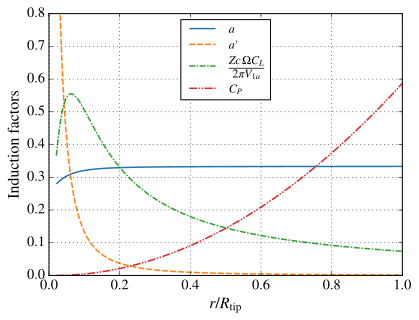

In [16]:
λ_vec  = []
ϕ_vec   = []
a_vec   = []
ap_vec  = []
EE_vec  = []
CP_vec  = []

for i, λ in enumerate( λ_set ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    EE  = 4.0 * ap * λ**2 / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    λ_vec.append( λ )
    a_vec.append( a )
    ap_vec.append( ap )
    ϕ_vec.append( ϕ )
    EE_vec.append( EE )

    if i > 0:
        CP += Integral_f( 1-3*a_vec[i], 1-3*a_vec[i-1] )
    else:
        CP = 0.0

    CP_vec.append( CP )

x_vec = np.array( λ_vec ) / λtip

mpl.plot( x_vec, a_vec,  label = r"$a$" )
mpl.plot( x_vec, ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, EE_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.ylabel( "Induction factors")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {CP_vec[-1]:.4f}" )

In [17]:
df = pd.DataFrame( { r"$\lambda$": λ_vec,
                     r"$a$": np.round(a_vec,decimals=5),
                     r"$a'$": np.round(ap_vec,decimals=5),
                     r"$C_P$": np.round(CP_vec,decimals=5),
                     r"$\phi$": np.round(ϕ_vec, decimals=2)*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": np.round(EE_vec, decimals=5)
                    } )

# print( df.to_latex(index=False,
#                   formatters={"name": str.upper},
#                   float_format="{:.3f}".format,
# ))
df

,$\lambda$,$a$,$a'$,$C_P$,$\phi$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$"
0,0.2500,0.27957,1.36349,0.00000,50.420286,0.36584
1,0.3125,0.28514,1.02881,0.00007,48.701413,0.42059
2,0.3750,0.29008,0.80936,0.00016,46.409581,0.46360
3,0.4375,0.29446,0.65560,0.00028,44.117750,0.49641
4,0.5000,0.29835,0.54276,0.00043,42.398877,0.52050
...,...,...,...,...,...,...
184,11.7500,0.33316,0.00161,0.56268,3.437747,0.07527
185,11.8125,0.33316,0.00159,0.56873,3.437747,0.07487
186,11.8750,0.33316,0.00157,0.57481,3.437747,0.07448
187,11.9375,0.33316,0.00156,0.58093,3.437747,0.07410


## Computing the turbine blade

C_P = 0.7390


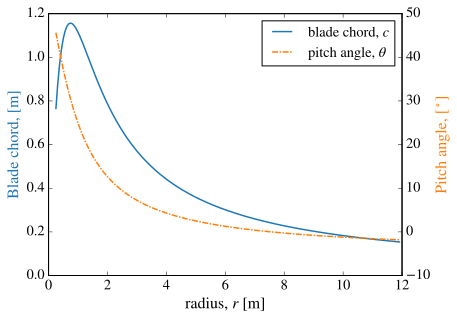

In [18]:
V1a = 2.5
Ω = 24.0 * np.pi / 30.0
Z = 3

α  = 5 * deg2rad
CL = 1.00
CD = 0.05
γ = np.arctan( CD / CL )

EE_factor = 2.0 * np.pi * V1a / ( Z * Ω * CL )

θ_vec = []
r_vec = []
c_vec = []
CP2_vec = []

for i, ( λ, a, ap, ϕ, EE ) in enumerate( zip( λ_vec, a_vec, ap_vec, ϕ_vec, EE_vec ) ):

    θ = ϕ - α
    r = λ * V1a / Ω
    c = EE * EE_factor
    η = np.sin( ϕ - γ ) / np.sin( ϕ )

    if i > 0:
        dλ = λ_vec[i] - λ_vec[i-1]
        CPm = 0.5 * ( CP_vec[i] + CP_vec[i-1] )
        CP2 = CP2_vec[i-1] + η * CPm * dλ
    else:
        CP2 = 0.0

    CP2_vec.append( CP2 )

    θ_vec.append( θ )
    r_vec.append( r )
    c_vec.append( c )

ax1 = mpl.gca()
ax1.plot( r_vec, c_vec, mut.linecolors[0], label="blade chord, $c$" )
ax1.set_ylabel( "Blade chord, [m]", color=mut.linecolors[0] )
ax1.set_xlabel( r"radius, $r$ [m]")
ax2 = mpl.gca().twinx()
ax2.plot( r_vec, np.array( θ_vec ) * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( "Pitch angle, [$^\circ$]", color=mut.linecolors[1] )

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineDesign.pdf" )

print( f"C_P = {CP2_vec[-1]:.4f}" )